In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
from igraph import *
import networkx as nx
import scipy.io
import math
import enum
import time
import nx_altair as nxa

## PARAMETERS

In [2]:
node_count = 30
simulated_graph_count = 100

In [3]:
# Plots strength distribution
def plot_strength_dist(G_list):
    for G in G_list:
        strengths = [G[e[0]][e[1]]['weight'] for e in G.edges()]
        plt.hist(strengths, alpha=0.5)
    plt.ylabel("P(s)")
    plt.xlabel("s")
    plt.title("Strength Distribution")
    plt.show()

# Plots degree distribution
def plot_degree_dist(G_list):
    for G in G_list:
        degrees = [G.degree(n) for n in G.nodes()]
        plt.hist(degrees, alpha=0.5)
    plt.ylabel("P(d)")
    plt.xlabel("d")
    plt.title("Degree Distribution")
    plt.show()
    
# Visualizes graph in an interactive window
def VisualizeGraph(G, title):
    pos = nx.spring_layout(G)

    chart = nxa.draw_networkx(
        G=G,
        pos=pos,
        width='weight:N'
    ).properties(title=title, height=500, width=500
    ).interactive()

    return chart

## 1- Graph datasets G1 and G2
    - K-regular Graph
    - Scale-Free Graph

    We gonna work on weighted-undirected networks.

In [4]:
# Creating our base graphs.
base_scale_free = nx.barabasi_albert_graph(node_count, 2, seed=61)
base_k_regular = nx.random_regular_graph(4, node_count, seed=61)

print("Scale free network node count: ", base_scale_free.number_of_nodes())
print("K-Regular network node count: ", base_k_regular.number_of_nodes())
print("Scale free network edge count: ", base_scale_free.number_of_edges())
print("K-Regular network edge count: ", base_k_regular.number_of_edges())

G_list = [base_k_regular, base_scale_free]

Scale free network node count:  30
K-Regular network node count:  30
Scale free network edge count:  56
K-Regular network edge count:  60


In [5]:
chart1 = VisualizeGraph(base_scale_free, "Random scale free graph")
chart1

alt.LayerChart(...)

In [6]:
chart2 = VisualizeGraph(base_k_regular, "Random K-Regular graph")
chart2

alt.LayerChart(...)

## Weights of Edges

- Weights will reflect the capacity of each edge (you can think of the capacity as quantity of information flows through this path)
- So we measure this capacity using edge betweenness centrality then normalize it with highest edge weight.


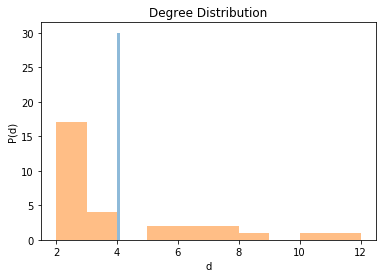

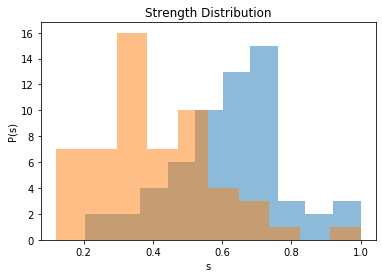

In [7]:
# Assignes weights for a given graph using edge betweenness centrality
def assignWeightToEdges(G):
    edges_weight = nx.edge_betweenness_centrality(G, normalized=False)
    maximum = max(edges_weight, key=edges_weight.get) 
    #Normalize with max edge weight
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = (edges_weight[e] / edges_weight[maximum])

# Assigning weights for our base graphs
assignWeightToEdges(base_k_regular)
assignWeightToEdges(base_scale_free)

G_base_list = [base_k_regular, base_scale_free]

plot_degree_dist(G_base_list)
plot_strength_dist(G_base_list)

## Adjaceny Matrix Visualization of Graphs

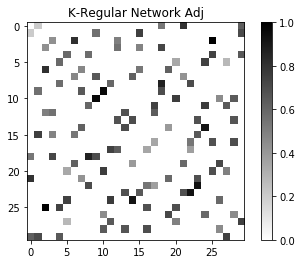

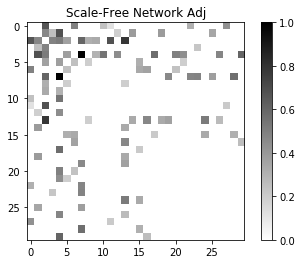

In [8]:
# Visualizes given adjacency matrix
def visuliazeAdj(G, name=""):
    data = nx.to_numpy_array(G)
    plt.imshow(data, cmap="binary")
    plt.colorbar()
    plt.title(name)
    plt.show()

visuliazeAdj(base_k_regular, "K-Regular Network Adj")
visuliazeAdj(base_scale_free, "Scale-Free Network Adj")

 ## Resilience in Weighted Networks
    
    ### We measure the resilience by using two properties of the graph

        - LCC Size (Largest Connected Component Size) will show how fast structure percolates (Local Property)
        - Global Efficieny will provide us to see efficiency of network globally even if network is separated to  multiple components.
        - Most of the previous works , generally focused on mostly local properties of graphs to measure resilience
    
    ### Attack Models

        Most of previous work they had targeted the nodes to see how  those affects the systems. However, in real-life systems, edge failure is also an important factor responsible for performance degradation. 

        - Target Attack: In each attack step, we remove the edge with the highest weight. Because highest weights edges carry most of the information
        - Random Attack: In each step, we randomly choose an edge and remove it. Because the random attack will represent the daily failures of the system.


In [9]:
# Returns graph with inverse of weights
def reciprocalOfEdges(G):
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = (1.0 / G[e[0]][e[1]]['weight'])

In [10]:
# Calculates global efficiency for a weighted graph
def global_eff(G):
    na = nx.to_numpy_array(G)
    g = Graph.Weighted_Adjacency(na.tolist())
    weights = g.es["weight"][:]
    sp = (1.0 / np.array(g.shortest_paths_dijkstra(weights=weights)))
    np.fill_diagonal(sp,0)
    N=sp.shape[0]
    ne= (1.0/(N-1)) * np.apply_along_axis(sum,0,sp)

    return np.mean(ne)

# Calculates global efficiency and Largest Connected Component Size
def global_and_lcc(G_temp):
    gleff = global_eff(G_temp)
    lcc = G_temp.subgraph(list(max(nx.connected_components(G_temp), key=len))).number_of_nodes()
    return gleff, lcc

# Target attack function. It delets the edges with highest weights.
def Attack_Highest_Weight(base_graph, number_of_attacks, Verbose = False):

    assert number_of_attacks > 1

    G_base_copy = base_graph.copy()
    # 1/w
    reciprocalOfEdges(G_base_copy)

    all_lcc_g_attacked_size = []
    gleff, lccs0 = global_and_lcc(G_base_copy)
    all_lcc_g_attacked_size.append(1)  

    all_global_efficiency_g_attacked = []
    all_global_efficiency_g_attacked.append(gleff)

    edge_list = sorted(G_base_copy.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
    
    last_out_time = time.time()
    for i in range(number_of_attacks - 1):
        if(i > base_graph.number_of_edges() - 2): 
            all_lcc_g_attacked_size.append(all_lcc_g_attacked_size[-1]) 
            all_global_efficiency_g_attacked.append(all_global_efficiency_g_attacked[-1]) 
        else:
            # calculate highest_weighted_edge 
            highest_weighted_edge = edge_list[-1]
            del edge_list[-1]
            # remove highest_weighted_edge from graph
            G_base_copy.remove_edge(highest_weighted_edge[0], highest_weighted_edge[1]) 

            # calculate largest connected component size 
            gleff, lccs = global_and_lcc(G_base_copy)     
            p = 1 - float(abs((lccs - lccs0))) / lccs0
            all_lcc_g_attacked_size.append(p)  
            all_global_efficiency_g_attacked.append(gleff)
        if(True == Verbose):
            if((time.time() - last_out_time) >= 1 or i+1 >= number_of_attacks - 1):
                clear_output()
                last_out_time = time.time()
                print("%", str(float(i+1) / number_of_attacks * 100))
        
    clear_output()
    print("%100") 
    return all_lcc_g_attacked_size, all_global_efficiency_g_attacked

# Random attack function. It deletes the edges randomly.
def Attack_Random(base_graph, number_of_attacks, Verbose = False):
    assert number_of_attacks > 1

    G_base_copy = base_graph.copy()
    reciprocalOfEdges(G_base_copy)

    all_lcc_g_attacked_size = []
    gleff, lccs0 = global_and_lcc(G_base_copy)   
    all_lcc_g_attacked_size.append(1)  
    
    all_global_efficiency_g_attacked = []
    all_global_efficiency_g_attacked.append(gleff)

    last_out_time = time.time()
    for i in range(number_of_attacks - 1):
        if(i> base_graph.number_of_edges() - 2): 
            all_lcc_g_attacked_size.append(all_lcc_g_attacked_size[-1]) 
            all_global_efficiency_g_attacked.append(all_global_efficiency_g_attacked[-1]) 
        else:
            random_edge = list(G_base_copy.edges())[rnd.randint(0, G_base_copy.number_of_edges() - 1)]
            G_base_copy.remove_edge(random_edge[0], random_edge[1])

            # calculate largest connected component size 
            gleff, lccs = global_and_lcc(G_base_copy)            
            p = 1 - float(abs((lccs - lccs0))) / lccs0
            all_lcc_g_attacked_size.append(p)  
            all_global_efficiency_g_attacked.append(gleff)
        if(True == Verbose):
            if((time.time() - last_out_time) >= 1 or i+1 >= number_of_attacks - 1):
                clear_output()
                last_out_time = time.time()
                print("%", str(float(i+1) / number_of_attacks * 100))
    
    clear_output()
    print("%100")
    return all_lcc_g_attacked_size, all_global_efficiency_g_attacked

def Save_Numpy(filename, array):
    with open(filename, 'wb') as f:
        np.save(f, array)
    
def Open_Numpy(filename, array):
    with open(filename, 'rb') as f:
        a = np.load(f)
    return a

attack_size = max(base_scale_free.number_of_edges(), base_k_regular.number_of_edges())

In [11]:
tgt_scf_lcc_g_attacked_size, tgt_scf_global_efficiency_g_attacked = Attack_Highest_Weight(base_scale_free, attack_size, True)

%100


In [12]:
tgt_kreg_lcc_g_attacked_size, tgt_kreg_global_efficiency_g_attacked = Attack_Highest_Weight(base_k_regular, attack_size, True)

%100


In [13]:
rnd_scf_lcc_g_attacked_size, rnd_scf_global_efficiency_g_attacked = Attack_Random(base_scale_free, attack_size, True)

%100


In [14]:
rnd_kreg_lcc_g_attacked_size, rnd_kreg_global_efficiency_g_attacked = Attack_Random(base_k_regular, attack_size, True)

%100


In [15]:
# plots given lists
def plot_list(list1_to_plot, list2_to_plot, title, x_title, y_title, color1, color2, label1, label2):
    attack_count_list = []
    for i in range(len(list1_to_plot)):
        attack_count_list.append(i)
    p = plt.plot(attack_count_list, list1_to_plot, color=color1, alpha=0.7)
    p = plt.plot(attack_count_list, list2_to_plot, color=color2, alpha=0.7)
    patch1 =  mpatches.Patch(color=color1, label=label1)
    patch2 =  mpatches.Patch(color=color2, label=label2)    
    plt.legend(handles=[patch1, patch2])
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.figure()

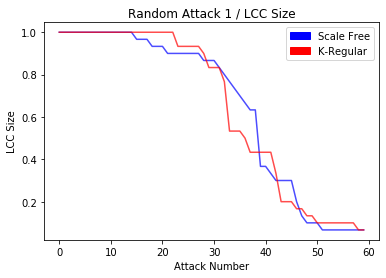

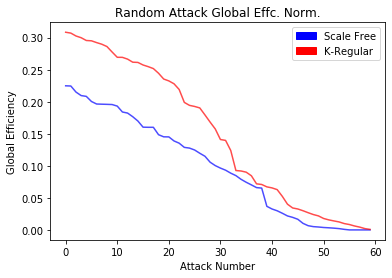

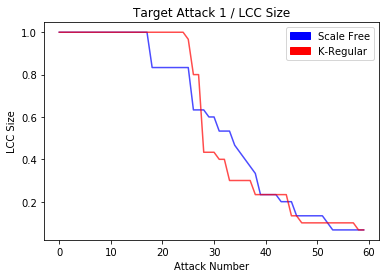

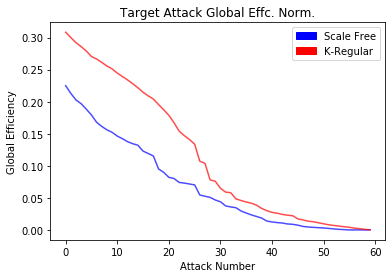

<Figure size 432x288 with 0 Axes>

In [16]:
plot_list(rnd_scf_lcc_g_attacked_size, rnd_kreg_lcc_g_attacked_size, "Random Attack-LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")
plot_list(rnd_scf_global_efficiency_g_attacked, rnd_kreg_global_efficiency_g_attacked, "Random Attack Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "K-Regular")

plot_list(tgt_scf_lcc_g_attacked_size, tgt_kreg_lcc_g_attacked_size, "Target Attack-LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")
plot_list(tgt_scf_global_efficiency_g_attacked, tgt_kreg_global_efficiency_g_attacked, "Target Attack Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "K-Regular")

## Null Models
 - We have used Rubinova and Sporns algorithm to create null Models
 - This null model preserves the strength distribution of graphs. 

In [17]:
# Following methods are received from Brain Connectivity Toolbox and we changed it a little bit to make it work with high node counts.
# We use the following methods to use null model for randomly generating graphs with same strength distribution as base graph.
def get_rng(seed=None):
    if seed is None or seed == np.random:
        return np.random.mtrand._rand
    elif isinstance(seed, np.random.RandomState):
        return seed
    try:
        rstate =  np.random.RandomState(seed)
    except ValueError:
        rstate = np.random.RandomState(random.Random(seed).randint(0, 2**32-1))
    return rstate

def pick_four_unique_nodes_quickly(n, seed=None):
    rng = get_rng(seed)
    k = rng.randint(n**4, dtype=np.int64)
    a = k % n
    b = k // n % n
    c = k // n ** 2 % n
    d = k // n ** 3 % n
    if (a != b and a != c and a != d and b != c and b != d and c != d):
        return (a, b, c, d)
    else:
        # the probability of finding a wrong configuration is extremely low
        # unless for extremely small n. if n is extremely small the
        # computational demand is not a problem.

        # In my profiling it only took 0.4 seconds to include the uniqueness
        # check in 1 million runs of this function so I think it is OK.
        return pick_four_unique_nodes_quickly(n, rng)

def randmio_und_signed(R, itr, seed=None):
    rng = get_rng(seed)
    R = R.copy()
    n = len(R)

    itr *= int(n * (n -1) / 2)

    max_attempts = int(np.round(n / 2))
    eff = 0

    for it in range(int(itr)):
        att = 0
        while att <= max_attempts:

            a, b, c, d = pick_four_unique_nodes_quickly(n, rng)

            r0_ab = R[a, b]
            r0_cd = R[c, d]
            r0_ad = R[a, d]
            r0_cb = R[c, b]

            #rewiring condition
            if (    np.sign(r0_ab) == np.sign(r0_cd) and
                    np.sign(r0_ad) == np.sign(r0_cb) and
                    np.sign(r0_ab) != np.sign(r0_ad)):

                R[a, d] = R[d, a] = r0_ab
                R[a, b] = R[b, a] = r0_ad

                R[c, b] = R[b, c] = r0_cd
                R[c, d] = R[d, c] = r0_cb

                eff += 1
                break

            att += 1

    return R, eff


def null_model_und_sign(W, bin_swaps=5, wei_freq=.1, seed=None):
    rng = get_rng(seed)
    if not np.allclose(W, W.T):
        raise BCTParamError("Input must be undirected")
    W = W.copy()
    n = len(W)
    np.fill_diagonal(W, 0)  # clear diagonal
    Ap = (W > 0)  # positive adjmat
    An = (W < 0)  # negative adjmat

    if np.size(np.where(Ap.flat)) < (n * (n - 1)):
        W_r, eff = randmio_und_signed(W, bin_swaps, seed=rng)
        Ap_r = W_r > 0
        An_r = W_r < 0
    else:
        Ap_r = Ap
        An_r = An

    W0 = np.zeros((n, n))
    for s in (1, -1):
        if s == 1:
            Acur = Ap
            A_rcur = Ap_r
        else:
            Acur = An
            A_rcur = An_r

        S = np.sum(W * Acur, axis=0)  # strengths
        Wv = np.sort(W[np.where(np.triu(Acur))])  # sorted weights vector
        i, j = np.where(np.triu(A_rcur))
        Lij, = np.where(np.triu(A_rcur).flat)  # weights indices

        P = np.outer(S, S)

        if wei_freq == 0:  # get indices of Lij that sort P
            Oind = np.argsort(P.flat[Lij])  # assign corresponding sorted
            W0.flat[Lij[Oind]] = s * Wv  # weight at this index
        else:
            wsize = np.size(Wv)
            wei_period = np.round(1 / wei_freq).astype(int)  # convert frequency to period
            lq = np.arange(wsize, 0, -wei_period, dtype=int)
            for m in lq:  # iteratively explore at this period
                # get indices of Lij that sort P
                Oind = np.argsort(P.flat[Lij])
                R = rng.permutation(m)[:np.min((m, wei_period))]
                for q, r in enumerate(R):
                    # choose random index of sorted expected weight
                    o = Oind[r]
                    W0.flat[Lij[o]] = s * Wv[r]  # assign corresponding weight

                    # readjust expected weighted probability for i[o],j[o]
                    f = 1 - Wv[r] / S[i[o]]
                    P[i[o], :] *= f
                    P[:, i[o]] *= f
                    f = 1 - Wv[r] / S[j[o]]
                    P[j[o], :] *= f
                    P[:, j[o]] *= f

                    # readjust strength of i[o]
                    S[i[o]] -= Wv[r]
                    # readjust strength of j[o]
                    S[j[o]] -= Wv[r]

                O = Oind[R]
                # remove current indices from further consideration
                Lij = np.delete(Lij, O)
                i = np.delete(i, O)
                j = np.delete(j, O)
                Wv = np.delete(Wv, R)

    W0 = W0 + W0.T

    rpos_in = np.corrcoef(np.sum(W * (W > 0), axis=0),
                          np.sum(W0 * (W0 > 0), axis=0))
    rpos_ou = np.corrcoef(np.sum(W * (W > 0), axis=1),
                          np.sum(W0 * (W0 > 0), axis=1))
    rneg_in = np.corrcoef(np.sum(-W * (W < 0), axis=0),
                          np.sum(-W0 * (W0 < 0), axis=0))
    rneg_ou = np.corrcoef(np.sum(-W * (W < 0), axis=1),
                          np.sum(-W0 * (W0 < 0), axis=1))
    return W0, (rpos_in[0, 1], rpos_ou[0, 1], rneg_in[0, 1], rneg_ou[0, 1])

def Null_Model(base_graph, count, Verbose=False):
    G_derived_list = []
    for i in range(count):
        a = null_model_und_sign(nx.to_numpy_array(base_graph), seed=61)
        G_derived_list.append(nx.from_numpy_array(a[0]))
        if(True == Verbose):
            clear_output()
            print("%", str(float(i+1) / count * 100))
    return G_derived_list

% 100.0


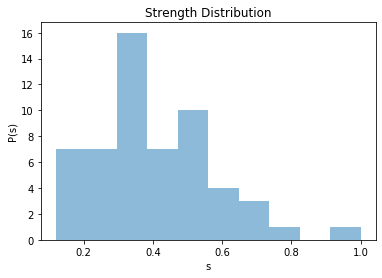

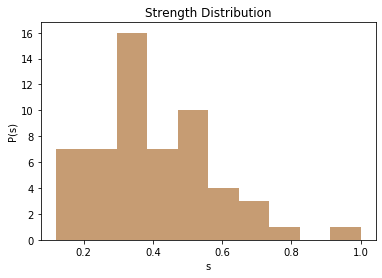

In [18]:
G_List_scf_null_model = Null_Model(base_scale_free, simulated_graph_count, True)
G_List_kreg_null_model = Null_Model(base_k_regular, simulated_graph_count, True)

# We show that strength distribution is remaining same after creating a new graph using null model.
rand_scf_graph = G_List_scf_null_model[rnd.randint(0, len(G_List_scf_null_model)-1)]
plot_strength_dist([rand_scf_graph])
plot_strength_dist([rand_scf_graph , base_scale_free])

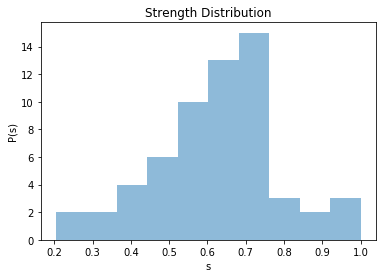

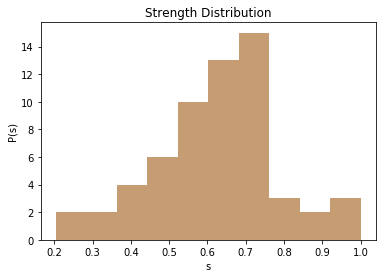

In [19]:
# We show that strength distribution is remaining same after creating a new graph using null model.
rand_kreg_graph = G_List_kreg_null_model[rnd.randint(0, len(G_List_kreg_null_model)-1)]
plot_strength_dist([rand_kreg_graph])
plot_strength_dist([rand_kreg_graph , base_k_regular])

## The Relation Ship Between Global Efficiency and Largest Connected Component Size

In [20]:
# We create lists to hold graph property results of all graphs.

G_SCF_sim_rand_attack_lcc_results_list = []
G_SCF_sim_rand_attack_gleff_results_list = []
G_SCF_sim_target_attack_lcc_results_list = []
G_SCF_sim_target_attack_gleff_results_list = []

G_KREG_sim_rand_attack_lcc_results_list = []
G_KREG_sim_rand_attack_gleff_results_list = []
G_KREG_sim_target_attack_lcc_results_list = []
G_KREG_sim_target_attack_gleff_results_list = []

last_out_time = time.time()
for i in range(len(G_List_scf_null_model)):
    rnd_lcc_result, rnd_gleff_result = Attack_Random(G_List_scf_null_model[i], attack_size)
    G_SCF_sim_rand_attack_lcc_results_list.append(rnd_lcc_result)
    G_SCF_sim_rand_attack_gleff_results_list.append(rnd_gleff_result)
    
    tgt_lcc_result, tgt_gleff_result = Attack_Highest_Weight(G_List_scf_null_model[i], attack_size)
    G_SCF_sim_target_attack_lcc_results_list.append(tgt_lcc_result)
    G_SCF_sim_target_attack_gleff_results_list.append(tgt_gleff_result)

    rnd_kreg_lcc_result, rnd_kreg_gleff_result = Attack_Random(G_List_kreg_null_model[i], attack_size)
    G_KREG_sim_rand_attack_lcc_results_list.append(rnd_kreg_lcc_result)
    G_KREG_sim_rand_attack_gleff_results_list.append(rnd_kreg_gleff_result)
    
    tgt_kreg_lcc_result, tgt_kreg_gleff_result = Attack_Highest_Weight(G_List_kreg_null_model[i], attack_size)
    G_KREG_sim_target_attack_lcc_results_list.append(tgt_kreg_lcc_result)
    G_KREG_sim_target_attack_gleff_results_list.append(tgt_kreg_gleff_result)

    if((time.time() - last_out_time) >= 1 or i+1 >= len(G_List_scf_null_model)):
        clear_output()
        last_out_time = time.time()
        print("%", str(float(i+1) / len(G_List_scf_null_model) * 100))

def list_mean(list_of_list):
    mean = []
    for i in range(len(list_of_list[0])):
        res = []
        for j in range(len(list_of_list)):
            res.append(list_of_list[j][i])
        mean.append(np.mean(res))
    return mean

SCF_Mean_rnd_lcc = list_mean(G_SCF_sim_rand_attack_lcc_results_list)
SCF_Mean_rnd_gleff = list_mean(G_SCF_sim_rand_attack_gleff_results_list)
SCF_Mean_tgt_lcc = list_mean(G_SCF_sim_target_attack_lcc_results_list)
SCF_Mean_tgt_gleff = list_mean(G_SCF_sim_target_attack_gleff_results_list)

KREG_Mean_rnd_lcc = list_mean(G_KREG_sim_rand_attack_lcc_results_list)
KREG_Mean_rnd_gleff = list_mean(G_KREG_sim_rand_attack_gleff_results_list)
KREG_Mean_tgt_lcc = list_mean(G_KREG_sim_target_attack_lcc_results_list)
KREG_Mean_tgt_gleff = list_mean(G_KREG_sim_target_attack_gleff_results_list)

% 100.0


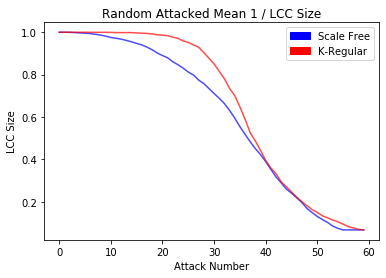

<Figure size 432x288 with 0 Axes>

In [21]:
plot_list(SCF_Mean_rnd_lcc, KREG_Mean_rnd_lcc, "Random Attacked Mean 1 / LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")

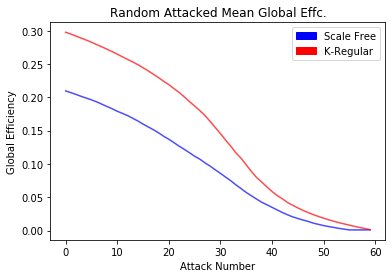

<Figure size 432x288 with 0 Axes>

In [22]:
plot_list(SCF_Mean_rnd_gleff, KREG_Mean_rnd_gleff, "Random Attacked Mean Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "K-Regular")

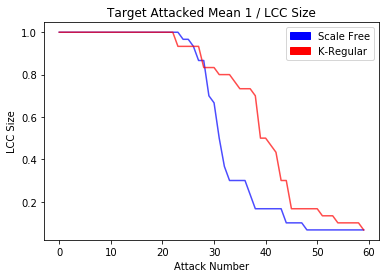

<Figure size 432x288 with 0 Axes>

In [23]:
plot_list(SCF_Mean_tgt_lcc, KREG_Mean_tgt_lcc, "Target Attacked Mean 1 / LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")

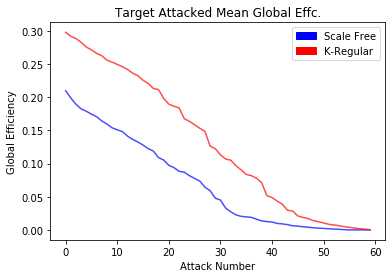

<Figure size 432x288 with 0 Axes>

In [24]:
plot_list(SCF_Mean_tgt_gleff, KREG_Mean_tgt_gleff, "Target Attacked Mean Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "K-Regular")

In [30]:
def scatter_plot_list(list1_to_plot, list2_to_plot, title, x_title, y_title, color1):
    plt.scatter(list1_to_plot, list2_to_plot, color=color1, alpha=0.7)
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)

SCF_LCC_List = []
KREG_LCC_List = []
SCF_GLEFF_List = []
KREG_GLEFF_List = []

for i in range(len(G_List_scf_null_model)):
    gleff, lccs = global_and_lcc(G_List_scf_null_model[i])
    SCF_LCC_List.append(lccs)
    SCF_GLEFF_List.append(gleff)
    gleff, lccs = global_and_lcc(G_List_kreg_null_model[i])
    KREG_LCC_List.append(lccs)
    KREG_GLEFF_List.append(gleff)

C:\Users\PC-N-086\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


## R- Space Looks like this because strength distribution is remained same in every simulation

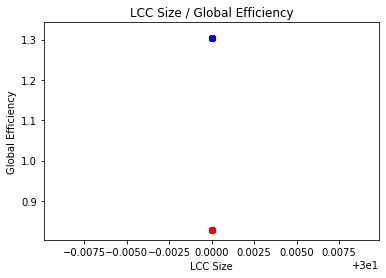

In [33]:
scatter_plot_list(SCF_LCC_List, SCF_GLEFF_List, "LCC Size / Global Efficiency", 'LCC Size', 'Global Efficiency', 'blue')
scatter_plot_list(KREG_LCC_List, KREG_GLEFF_List, "LCC Size / Global Efficiency", 'LCC Size', 'Global Efficiency', 'red')

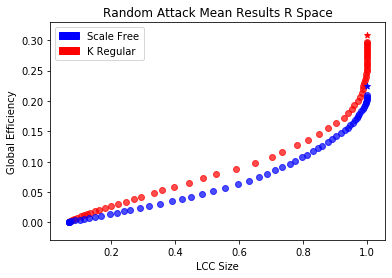

In [42]:
# Random attack mean results
scatter_plot_list(KREG_Mean_rnd_lcc, KREG_Mean_rnd_gleff, "Random Attack Mean Results R Space", 'LCC Size', 'Global Efficiency', 'red')
scatter_plot_list(SCF_Mean_rnd_lcc, SCF_Mean_rnd_gleff, "Random Attack Mean Results R Space", 'LCC Size', 'Global Efficiency', 'blue')
patch1 =  mpatches.Patch(color='blue', label='Scale Free')
patch2 =  mpatches.Patch(color='red', label='K Regular')
plt.scatter(rnd_scf_lcc_g_attacked_size[0], rnd_scf_global_efficiency_g_attacked[0], color='blue', marker='*')
plt.scatter(rnd_kreg_lcc_g_attacked_size[0], rnd_kreg_global_efficiency_g_attacked[0], color='red', marker='*')
plt.legend(handles=[patch1, patch2])

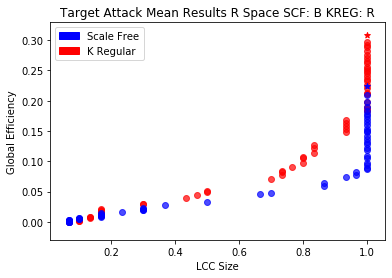

In [43]:
# Target attack mean results
scatter_plot_list(KREG_Mean_tgt_lcc, KREG_Mean_tgt_gleff, "Target Attack Mean Results R Space SCF: B KREG: R", 'LCC Size', 'Global Efficiency', 'red')
scatter_plot_list(SCF_Mean_tgt_lcc, SCF_Mean_tgt_gleff, "Target Attack Mean Results R Space SCF: B KREG: R", 'LCC Size', 'Global Efficiency', 'blue')
patch1 =  mpatches.Patch(color='blue', label='Scale Free')
patch2 =  mpatches.Patch(color='red', label='K Regular')    
plt.scatter(tgt_scf_lcc_g_attacked_size[0], tgt_scf_global_efficiency_g_attacked[0], color='blue', marker='*')
plt.scatter(tgt_kreg_lcc_g_attacked_size[0], tgt_kreg_global_efficiency_g_attacked[0], color='red', marker='*')
plt.legend(handles=[patch1, patch2])

### Our Conclusions 
    - Scale free networks are resilient to random attacks than target attacks.
    - In terms of global efficiency looks like Scale-Free networks more resilient than the K-reqular in case of different attack types
    - But Scale-Free Networks are sensitive to the fragmentation if highest weight edges are targeted.
    - It seems that node count doesnt change the relationship between global efficiency and LCC size.